# Single FENE chain analysis
Here we will be only looking at a single chain and what tools are available to plot the dynamics.

In [1]:
import numpy as np
from dilutebrowniandynamics.simulate import simulate
from dilutebrowniandynamics.molecules.FENE_chain import FENEChain

## Parameters definition

In [2]:
n_links = 50       # Number of segments in the Kramers chain
L_max = 20         # Maximum elongation of each link: reminder: equilibirum length is 3.

output_file = 'outputs/sandpit'

## Initialise molecules
Here we just draw random vectors from a normal distribution and rescale to unit vectors. To do this with call `from_normal_distribution` constructor. 

In [3]:
# Starting vectors
molecule = FENEChain.from_normal_distribution(n_links, L_max, np.random.SeedSequence(2023))

We can plot this molecule using matplotlib 3d capabilities: firt we need to convert links to coordinates.

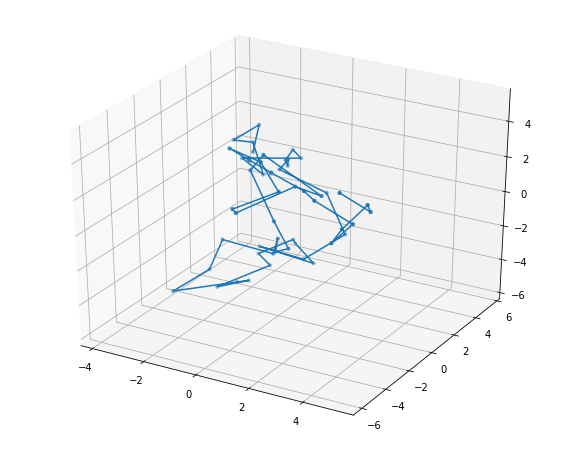

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [10, 8]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xyz = molecule.coordinates
x, y, z = xyz[:,0], xyz[:,1], xyz[:,2]
ax.plot(x, y, z)
ax.scatter(x, y, z, s=10)

Or we can export the molecule to vtk format which can be read by Paraview.

In [5]:
molecule.save_vtk('outputs/vtk/example.vtk')

## Initial relaxation
Thermalisation step.

In [6]:
gradU = np.zeros((3, 3))
dt = 0.01
n_steps = 100

observables, molecule_out = simulate(molecule, gradU, dt, n_steps,
                                     write_interval=1, full_trajectory=False, progress=True)

100%|██████████| 100/100 [00:01<00:00, 86.30it/s]


## Simulation
Now let's simulate a sudden uniaxial elongation followed by relaxation. We first define a callable `gradU` function for this scenario.

In [7]:
from scipy.interpolate import interp1d
t_base = [0, # Elongation starts at t = 0
          10] # Relaxation will start from t = 5
gradU_base = [np.diag([1, -.5, -.5]),
              np.zeros((3, 3))]
gradU = interp1d(t_base, gradU_base, axis=0, kind='previous', bounds_error=False, 
                 fill_value=(gradU_base[0], gradU_base[-1]), assume_sorted=True)

In [8]:
n_steps = 500
dt = 0.01
observables, trajectory = simulate(molecule_out, gradU, dt, n_steps,
                                     write_interval=1, full_trajectory=True, progress=True)

 70%|██████▉   | 348/500 [00:00<00:00, 1722.66it/s]/home/etienne/Python/DiluteBrownianDynamics/dilutebrowniandynamics/molecules/FENE_chain.py:109: RuntimeWarning: overflow encountered in square
  while any(np.sum(new_Q**2, axis=1) > self.L_max**2 - LENGTH_TOL):
100%|██████████| 500/500 [00:53<00:00,  9.32it/s]  


In [9]:
for i in range(0,len(trajectory),1):
    trajectory[i].save_vtk(f'outputs/vtk/time_{i}.vtk')

## Analysing tensions in the molecule

We can analysed the trajectory (collection of time steps) interactively in this Notebook:

In [10]:
from ipywidgets import interact
x_min = np.min(np.array([molecule.coordinates[:,0] for molecule in trajectory]))
x_max = np.max(np.array([molecule.coordinates[:,0] for molecule in trajectory]))
y_min = np.min(np.array([molecule.coordinates[:,1] for molecule in trajectory]))
y_max = np.max(np.array([molecule.coordinates[:,1] for molecule in trajectory]))
z_min = np.min(np.array([molecule.coordinates[:,2] for molecule in trajectory]))
z_max = np.max(np.array([molecule.coordinates[:,2] for molecule in trajectory]))
min_min = min(x_min, y_min, z_min)
max_max = max(x_max, y_max, z_max)

@interact
def display_molecule(step=(0,len(trajectory)-1,1)):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    molecule = trajectory[step]
    xyz = molecule.coordinates
    x, y, z = xyz[:,0], xyz[:,1], xyz[:,2]
    c = np.zeros_like(x)
    c[:-1] = 0.5*molecule.tensions
    c[1:] = 0.5*molecule.tensions
    ax.plot(x, y, z)
    im = ax.scatter(x, y, z, s=10, c=c)
    ax.scatter([min_min, max_max], [min_min, max_max], [min_min, max_max], s=0)
    fig.colorbar(im, ax=ax, label='Dimensionless tension')
    plt.show()


interactive(children=(IntSlider(value=249, description='step', max=499), Output()), _dom_classes=('widget-inte…

Or we can save a sequence of vtk files to make an animation later in Paraview:

In [11]:
for i in range(0,len(trajectory),10):
    trajectory[i].save_vtk(f'outputs/vtk/time_{i}.vtk')

To see how the molecule unravels, we can plot tension as function of time in a 2d plot:

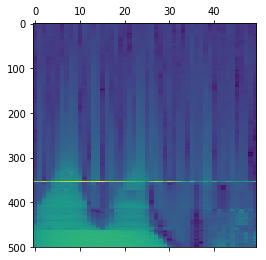

In [12]:
mat = np.empty((n_steps,n_links))
for i in range(n_steps):
    mat[i] = trajectory[i].tensions
    
plt.matshow(np.log(abs(mat)), aspect=0.1)

## Performance profiling

In [13]:
%load_ext line_profiler

In [14]:
# Starting vectors
molecule = KramersChain.from_normal_distribution(n_links)

NameError: name 'KramersChain' is not defined

In [ ]:
# Simulation routine
#
# This shows that the method `solve` is the most expensive.
%lprun -f simulate simulate(molecule, np.zeros((3,3)), 10, 0.01, full_trajectory=False, progress=True)

In [ ]:
# solve
#%lprun -f KramersChain.solve molecule.solve(np.zeros((3,3)), 0.001)

In [ ]:
1024**0.5